In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import chain, combinations

In [14]:
class FPNode:
    """
    Represents a node in the FP-Tree.
    """
    def __init__(self, item_name, frequency, parent_node):
        """
        Initializes the node.

        Parameters:
        - item_name (str): The item name.
        - frequency (int): The frequency count.
        - parent_node (FPNode): The parent node.
        """
        self.item_name = item_name
        self.frequency = frequency
        self.parent_node = parent_node
        self.children_nodes = {}
        self.next_node = None

    def increment(self, frequency):
        """
        Increments the count of the node.

        Parameters:
        - frequency (int): The count to add.
        """
        self.frequency += frequency


In [16]:
class FPGrowthAlgorithm:
    def __init__(self):
        pass

    def prepare_datasets(self, movies_filepath, ratings_filepath, rating_cutoff=2, min_user_ratings=10, train_fraction=0.8):
        movies_data = pd.read_csv(movies_filepath)
        ratings_data = pd.read_csv(ratings_filepath)

        merged_data = pd.merge(movies_data, ratings_data, on='movieId', how='inner')

        filtered_data = merged_data[merged_data["rating"] > rating_cutoff]
        filtered_data = filtered_data[filtered_data.groupby('userId')["userId"].transform('size') > min_user_ratings]

        train_data_frame = filtered_data.groupby('userId', group_keys=False).sample(frac=train_fraction, random_state=42)
        test_data_frame = filtered_data.drop(train_data_frame.index)

        train_data = train_data_frame.groupby('userId')['title'].apply(list).to_dict()
        test_data = test_data_frame.groupby('userId')['title'].apply(list).to_dict()

        return train_data, test_data

    def update_header(self, item_name, node, header_table):
        if header_table[item_name][1] is None:
            header_table[item_name][1] = node
        else:
            current_node = header_table[item_name][1]
            while current_node.next_node:
                current_node = current_node.next_node
            current_node.next_node = node

    def insert_tree(self, sorted_items, current_node, header_table, frequency):
        first_item = sorted_items[0]
        if first_item in current_node.children_nodes:
            current_node.children_nodes[first_item].increment(frequency)
        else:
            new_node = FPNode(first_item, frequency, current_node)
            current_node.children_nodes[first_item] = new_node
            self.update_header(first_item, new_node, header_table)
        if len(sorted_items) > 1:
            self.insert_tree(sorted_items[1:], current_node.children_nodes[first_item], header_table, frequency)

    def build_fp_tree(self, transaction_data, min_support_threshold):
        item_frequency = defaultdict(int)
        for transaction in transaction_data:
            for item in transaction:
                item_frequency[item] += 1

        header_table = {item: [freq, None] for item, freq in item_frequency.items() if freq >= min_support_threshold}
        if not header_table:
            return None, None

        sorted_transactions = []
        for transaction in transaction_data:
            filtered_items = sorted([item for item in transaction if item in header_table],
                                    key=lambda x: header_table[x][0], reverse=True)
            if filtered_items:
                sorted_transactions.append(filtered_items)

        root_node = FPNode('Root', 1, None)
        for trans in sorted_transactions:
            self.insert_tree(trans, root_node, header_table, 1)

        return root_node, header_table

    def find_prefix_paths(self, base_item, header_table):
        paths = []
        counts = []
        node = header_table[base_item][1]
        while node:
            path = []
            parent_node = node.parent_node
            while parent_node and parent_node.item_name != 'Root':
                path.append(parent_node.item_name)
                parent_node = parent_node.parent_node
            if path:
                paths.append(path[::-1])
                counts.append(node.frequency)
            node = node.next_node
        return paths, counts

    def mine_fp_tree(self, header_table, min_support_threshold, current_prefix, frequent_itemsets):
        sorted_items = sorted(header_table.items(), key=lambda x: x[1][0])
        for base_item, (frequency, node) in sorted_items:
            new_prefix = current_prefix.copy()
            new_prefix.add(base_item)
            frequent_itemsets.append(new_prefix)

            conditional_paths, conditional_counts = self.find_prefix_paths(base_item, header_table)

            conditional_tree, conditional_header = self.build_fp_tree(conditional_paths, min_support_threshold)

            if conditional_header:
                self.mine_fp_tree(conditional_header, min_support_threshold, new_prefix, frequent_itemsets)

    def calculate_support(self, itemset, transaction_data):
        return sum(1 for transaction in transaction_data if itemset.issubset(transaction))

    def generate_rules(self, frequent_itemsets, transaction_data, min_confidence_threshold):
        support_rules = []
        confident_rules = []

        for itemset in frequent_itemsets:
            if len(itemset) < 2:
                continue
            itemset_support = self.calculate_support(itemset, transaction_data)
            for antecedent in chain.from_iterable(combinations(itemset, r) for r in range(1, len(itemset))):
                antecedent_set = set(antecedent)
                consequent_set = itemset - antecedent_set
                antecedent_support = self.calculate_support(antecedent_set, transaction_data)
                if antecedent_support > 0:
                    confidence = itemset_support / antecedent_support
                    support_rules.append((antecedent_set, consequent_set, itemset_support))
                    if confidence >= min_confidence_threshold:
                        confident_rules.append((frozenset(antecedent_set), frozenset(consequent_set), confidence))

        support_rules = [(frozenset(antecedent), frozenset(consequent), support)
                         for antecedent, consequent, support in support_rules]

        return support_rules, confident_rules

    def execute_fp_growth(self, transaction_data, min_support_threshold, min_confidence_threshold):
        tree, header = self.build_fp_tree(transaction_data, min_support_threshold)
        if not header:
            print("No frequent itemsets found.")
            return [], [], []

        frequent_itemsets = []
        self.mine_fp_tree(header, min_support_threshold, set(), frequent_itemsets)

        support_rules, confident_rules = self.generate_rules(frequent_itemsets, transaction_data, min_confidence_threshold)

        return frequent_itemsets, support_rules, confident_rules

    def calculate_precision_and_recall(self, training_data, testing_data, rules, top_k=10):
        avg_precisions = []
        avg_recalls = []

        for k in range(1, top_k + 1):
            precision_scores = []
            recall_scores = []

            for user, test_items in testing_data.items():
                if user not in training_data:
                    continue
                train_items = set(training_data[user])
                test_set = set(test_items)

                recommendations = []
                for antecedent, consequent, confidence in rules:
                    if antecedent & train_items:
                        recommendations.append((consequent, confidence))

                top_rules = sorted(recommendations, key=lambda x: -x[1])[:k]
                recommended_items = set(chain.from_iterable([rec[0] for rec in top_rules]))

                hits = test_set & recommended_items
                if recommended_items:
                    precision = len(hits) / len(recommended_items)
                    recall = len(hits) / len(test_set)
                    precision_scores.append(precision)
                    recall_scores.append(recall)

            avg_precision_value = np.mean(precision_scores) if precision_scores else 0
            avg_recall_value = np.mean(recall_scores) if recall_scores else 0
            avg_precisions.append(avg_precision_value)
            avg_recalls.append(avg_recall_value)

        return avg_precisions, avg_recalls

    def plot_precision_recall_graph(self, avg_precision_values, avg_recall_values, max_k=10):
        ks = range(1, max_k + 1)
        plt.figure(figsize=(10, 6))
        plt.plot(ks, avg_precision_values, label="Average Precision Score", marker='o')
        plt.plot(ks, avg_recall_values, label="Average Recall Score", marker='x', linestyle='--')
        plt.xlabel("Top k Rules")
        plt.ylabel("Average Score Value")
        plt.title("Precision and Recall Analysis Across Different Rule Thresholds")
        plt.legend()
        plt.grid(True)
        plt.show()


    def user_precision_recall(self, user_identifier, training_data, testing_data, association_rules, max_k=10):
        precision_at_k = []
        recall_at_k = []

        if user_identifier not in training_data or user_identifier not in testing_data:
            return precision_at_k, recall_at_k

        train_items = set(training_data[user_identifier])
        test_items = set(testing_data[user_identifier])

        recommendations = []
        for antecedent, consequent, confidence in association_rules:
            if antecedent & train_items:
                recommendations.append((consequent, confidence))

        top_rules = sorted(recommendations, key=lambda x: -x[1])[:max_k]
        recommended_items = set()

        for k in range(1, max_k + 1):
            if k <= len(top_rules):
                recommended_items.update(top_rules[k-1][0])
                hits = test_items & recommended_items
                if recommended_items:
                    precision = len(hits) / len(recommended_items)
                    recall = len(hits) / len(test_items)
                    precision_at_k.append(precision)
                    recall_at_k.append(recall)

        return precision_at_k, recall_at_k

    def plot_user_precision_recall(self, user_identifier, precision_values, recall_values):
        ks = range(1, len(precision_values) + 1)
        plt.figure(figsize=(8, 6))
        plt.plot(ks, precision_values, label="Precision Score", marker='o')
        plt.plot(ks, recall_values, label="Recall Score", marker='x', linestyle='--')
        plt.xlabel("Top k Rules")
        plt.ylabel("Score Value")
        plt.title(f"Precision and Recall Analysis for User {user_identifier}")
        plt.legend()
        plt.grid(True)
        plt.show()


    def evaluate_sample_users(self, sample_user_ids, training_data, testing_data, association_rules, max_k=10):
        for user in sample_user_ids:
            precision_values, recall_values = self.user_precision_recall(user, training_data, testing_data, association_rules, max_k)
            if precision_values and recall_values:
                self.plot_user_precision_recall(user, precision_values, recall_values)
            else:
                print(f"No recommendations available for User {user}.")

    def save_rules(self, output_path, association_rules, sort_by='support'):
        if sort_by == 'support':
            sorted_rules = sorted(association_rules, key=lambda x: x[2], reverse=True)
        elif sort_by == 'confidence':
            sorted_rules = sorted(association_rules, key=lambda x: x[2], reverse=True)
        else:
            sorted_rules = association_rules

        with open(output_path, "w") as f:
            for antecedent, consequent, value in sorted_rules:
                antecedent_str = ', '.join(antecedent)
                consequent_str = ', '.join(consequent)
                f.write(f"{antecedent_str} => {consequent_str} ({value:.2f})\n")


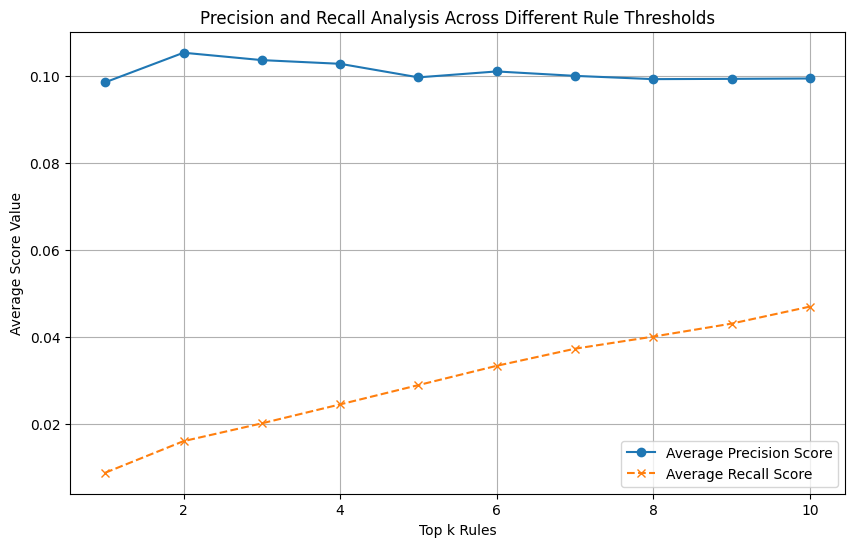

Evaluating Precision and Recall for Users: [1, 6, 8]


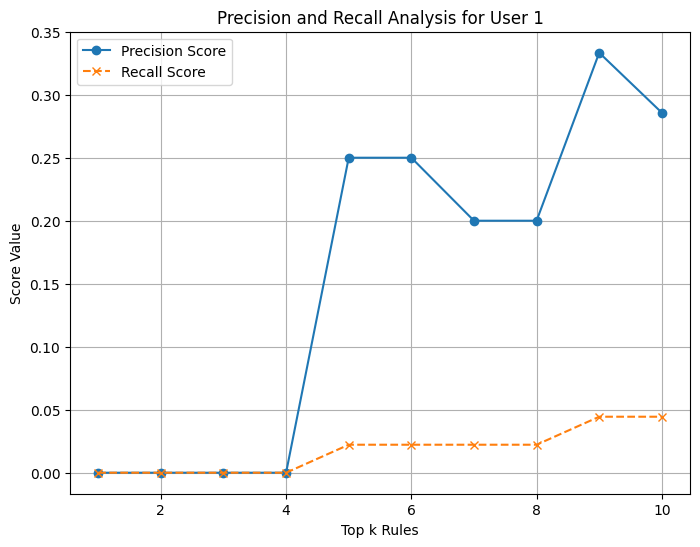

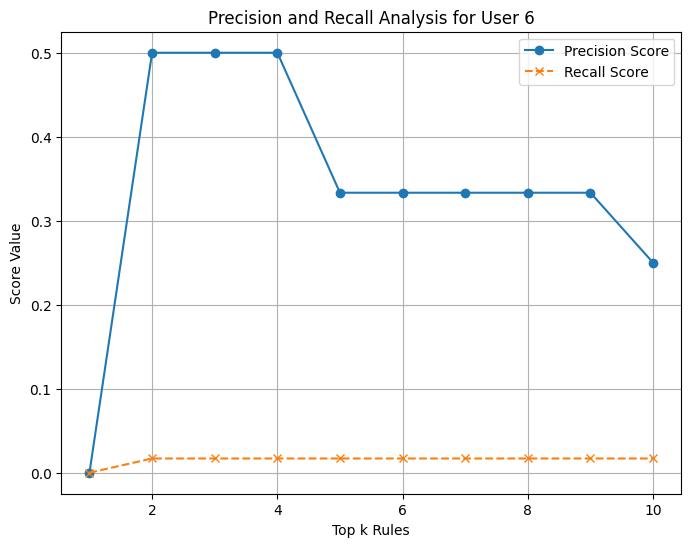

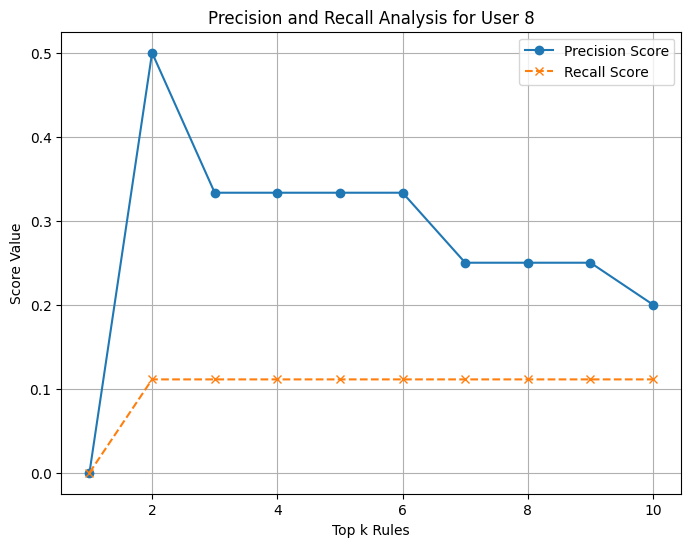

In [17]:
def main():
    fp_growth_instance = FPGrowthAlgorithm()

    movies_filepath = "movies.csv"
    ratings_filepath = "ratings.csv"

    training_transactions, testing_transactions = fp_growth_instance.prepare_datasets(
        movies_filepath, ratings_filepath,
        # rating_threshold=2,
        # min_ratings_per_user=10,
        # train_frac=0.8
    )

    transaction_collection = list(training_transactions.values())

    minimum_support = 40
    minimum_confidence = 0.2
    frequent_itemsets, support_rules, confident_rules = fp_growth_instance.execute_fp_growth(transaction_collection, minimum_support, minimum_confidence)

    avg_precision, avg_recall = fp_growth_instance.calculate_precision_and_recall(training_transactions, testing_transactions, confident_rules, top_k=10)
    fp_growth_instance.plot_precision_recall_graph(avg_precision, avg_recall, max_k=10)

    desired_user_identifiers = [1, 6, 8]

    sample_user_identifiers = [user for user in desired_user_identifiers if user in testing_transactions]

    missing_users = set(desired_user_identifiers) - set(sample_user_identifiers)
    if missing_users:
        print(f"Warning: The following users are not present in the test set and will be skipped: {missing_users}")

    if sample_user_identifiers:
        print(f"Evaluating Precision and Recall for Users: {sample_user_identifiers}")
        fp_growth_instance.evaluate_sample_users(sample_user_identifiers, training_transactions, testing_transactions, confident_rules, max_k=10)
    else:
        print("No specified users found in the test set for evaluation.")

    top_supporting_rules = sorted(support_rules, key=lambda x: x[2], reverse=True)[:100]
    top_confidence_rules = sorted(confident_rules, key=lambda x: x[2], reverse=True)[:100]

    fp_growth_instance.save_rules("top100RulesBySupport.txt", top_supporting_rules, sort_by='support')
    fp_growth_instance.save_rules("top100RulesByConfidence.txt", top_confidence_rules, sort_by='confidence')

    support_rule_set = set(tuple(rule) for rule in top_supporting_rules)
    confidence_rule_set = set(tuple(rule) for rule in top_confidence_rules)
    common_rules = support_rule_set.intersection(confidence_rule_set)

    common_rules_sorted = sorted(common_rules, key=lambda x: x[2], reverse=True)

    fp_growth_instance.save_rules("commonRulesByConfidence.txt", common_rules_sorted, sort_by='confidence')


if __name__ == "__main__":
    main()


# Inference: Plot of average precision and average recall by varying the number of rules from 1 to 10


   - The precision stays steady at around 0.10 across different rule thresholds (k). This shows that the top recommendations from your FP-Growth algorithm are very relevant and accurate, even as the number of rules increases. High precision consistently indicates a strong recommendation system that offers useful suggestions to users.

- As the number of top rules (k) goes up, the recall also improves steadily. This means that the FP-Growth algorithm is successfully finding a wider range of relevant items when more rules are added. The increasing recall is a good sign that the recommendation system is covering more ground, making it more likely to suggest items that users would find relevant over time.

- The model maintains a good balance between precision and recall, which is important for recommendation systems. While recall increases, precision doesn’t drop much. This balance ensures that users get recommendations that are both accurate and comprehensive, leading to a better experience.


# Inference: plot for user 1

- The recommendation system is providing very relevant suggestions for User 1, particularly at certain rule thresholds, which shows strong precision for the top rules. However, more strategies might be necessary to enhance recall and explore a wider range of potential interests.

# Inference: Plot for user 6

- The system gives very accurate recommendations for the top rules, especially between
k=2 and
k=4. This means it can effectively suggest relevant movies for User 6 in the early recommendations. The algorithm is really good at making focused suggestions right from the start.

# Inference : Plot for user 8

- The system does a great job of giving very accurate recommendations for User 8, especially at the top rule threshold (
k=2). The algorithm successfully suggests relevant options right from the beginning, although there is still room to improve its overall coverage (recall).